<a href="https://www.kaggle.com/code/dharmaputra13/structured-analisis-tugas?scriptVersionId=120855208" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A. Mengimport Library yang digunakan

In [1]:
import pandas as pd  ## Library untuk membaca dataset ke dalam bentuk dataframe
import plotly.express as px  ## Library untuk melakukan plotting
import seaborn as sns ## Library untuk plotting (Tidak digunakan)
import matplotlib.pyplot as plt ## Librry untuk plotting
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  ## Library untuk melakukan plotting wordcloud, 
                                                                #melakukan stopwords, serta mewarnai word di wordcloud
# Import Required libraries
import numpy as np  ## Library untuk berurusan dengan matriks jika diperlukan
from bs4 import BeautifulSoup  ## Library scrapping
import requests ## request url web
from csv import writer ## untuk melakukan write pada csv
import re ## Regex
import nltk ## Library untuk melakukan stop words dan Lemmatixer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer


# B. Analisis structured data

In [2]:
df=pd.read_csv('/kaggle/input/scrape/house_scraped.csv') 

<b> Dataset ini sebelumnnya telah saya scrap dari web lamudi.com 
    lalu saya upload ke github </b> 
    
*   Link github scrapping : https://github.com/kbdp1305/lamudiscrap.git
*   Web scrapping ini saya lakukan di tools VS CODE di laptop saya, sehingga yang
    ada di notebook ini tidak saya run



## Implementasi coding webscrapping : 

In [ ]:
from bs4 import BeautifulSoup


# url='https://www.lamudi.co.id/yogyakarta/house/buy/'
url='https://www.lamudi.co.id/yogyakarta/house/buy/?page=0'
page=requests.get(url)
start=2
with open("house_scraped.csv",'w',encoding='utf8',newline='') as f :
    writers=writer(f)
    header=['rumah','alamat',"harga","temppat_tidur","luas_bangunan","luas_lahan"]
    writers.writerow(header)
    while page.ok and start < 101 :
        soup=BeautifulSoup(page.content, 'html.parser')

        lists=soup.find_all('div',class_="ListingCell-AllInfo ListingUnit")
        for list in lists :
            nama_rumah=list.find('h2',class_="ListingCell-KeyInfo-title").text.replace("\n","").lstrip().strip().replace(".",'')
            location=list.find('span',class_="ListingCell-KeyInfo-address-text").getText().lstrip().strip()
            harga=list.find('span',class_='PriceSection-FirstPrice').text.lstrip().strip()
    # tempat_tidur=list.find('span',class_='KeyInformation-value_v2').text.replace(" ","").replace("\n","")[0]
            tempat_tidur=int(list.find('span',class_='KeyInformation-value_v2').find_next('span').next_sibling.strip())
            luas_bangunan_m_kuadrat=int(list.find('span',class_="KeyInformation-value_v2").find_next('span','icon-livingsize').next_sibling.strip().replace(" ","").replace("m²",""))
            luas_lahan=list.find('span',class_="KeyInformation-value_v2").find_next('span','icon-land_size').next_sibling.strip().replace(" ","").replace("m²","").lstrip().strip()
            writers.writerow([nama_rumah,location,harga,tempat_tidur,luas_bangunan_m_kuadrat,luas_lahan])
         
        url='https://www.lamudi.co.id/yogyakarta/house/buy/?page=0'
        url=url.replace('0',str(start))
        start+=1
        page=requests.get(url)


    
    



*  Hasil scrapping web ini adalah csv file berisi variabel rumah,alamat,harga,temppat_tidur,luas_bangunan, dan luas lahan.
*  Berikut preview dari file csv hasil scrapping 

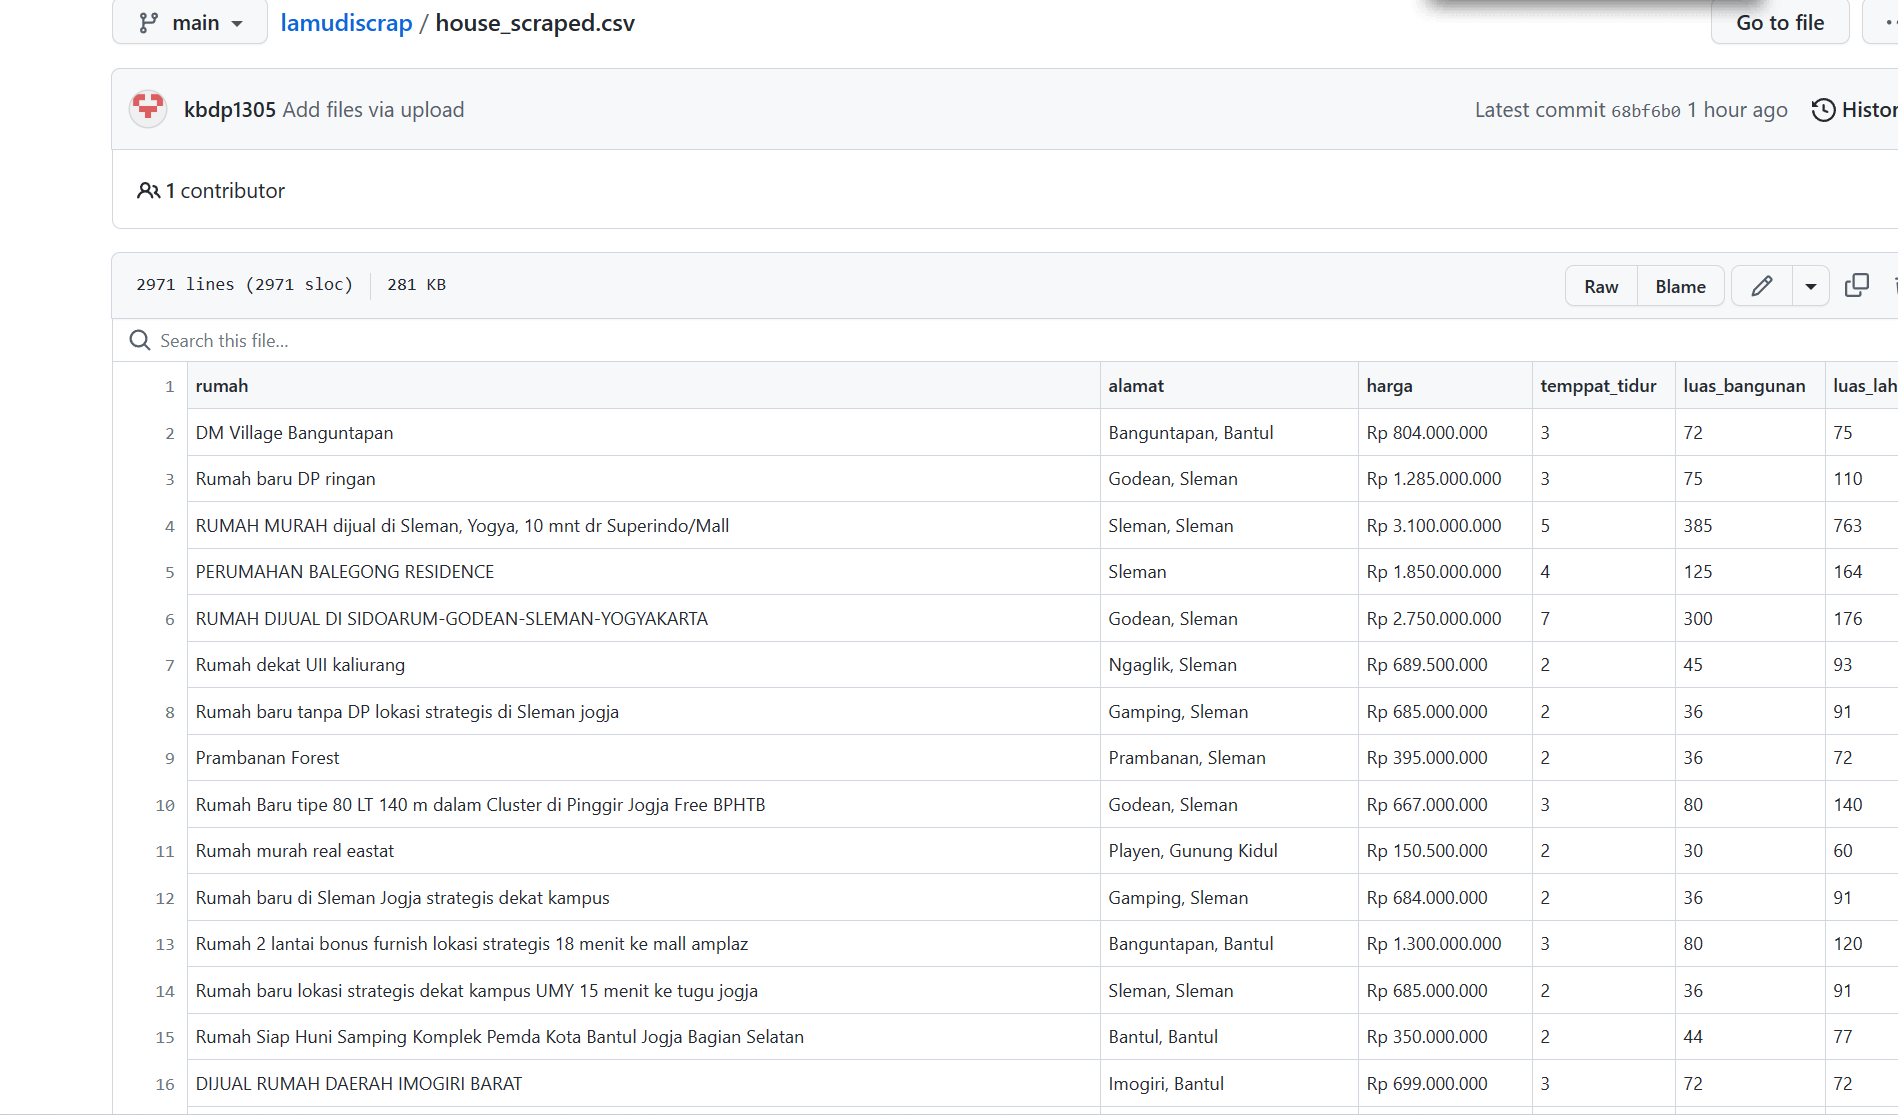

## Melakukan cleaning data

### Drop duplicate

<b> Pada dataset ini, terdapat beberapa data yang berulang, sehingga kita perlu menghilangkan data duplikat ini agar dataset yang didapatkan 
    semuanya unique </b>

In [3]:
dup_index=df[df.duplicated()].index
df=df.drop(index=dup_index,axis=0) ## Drop duplicated rows
df.reset_index(drop=True,inplace=True)

In [4]:
df[df.duplicated()]

Empty DataFrame
Columns: [rumah, alamat, harga, temppat_tidur, luas_bangunan, luas_lahan]
Index: []

In [ ]:
a=df[df.duplicated()==True]["rumah"][300]

In [ ]:
df[df["rumah"]==a]

In [5]:
def kabupaten(data) :
    if "," in data :
        return data.split(",")[1].lstrip()
    else :
        return data.lstrip()

In [6]:
df['alamat']=df['alamat'].apply(lambda x:kabupaten(x))

In [7]:
df['alamat'].unique()

array(['Bantul', 'Sleman', 'Gunung Kidul', 'Yogyakarta', 'Kulon Progo',
       'Kotagede', 'Gondokusuman'], dtype=object)

In [8]:
def turn_kemantren(data) :
    kemantren=['Kotagede','Gondokusuman']
    if data in kemantren :
        return ("Yogyakarta")
    else :
        return data
    

In [9]:
df['alamat']=df['alamat'].apply(lambda x:turn_kemantren(x))

In [10]:
df

rumah  alamat  \
0                                DM Village Banguntapan  Bantul   
1                                  Rumah baru DP ringan  Sleman   
2     RUMAH MURAH dijual di Sleman, Yogya, 10 mnt dr...  Sleman   
3                          PERUMAHAN BALEGONG RESIDENCE  Sleman   
4     RUMAH DIJUAL DI SIDOARUM-GODEAN-SLEMAN-YOGYAKARTA  Sleman   
...                                                 ...     ...   
2530  Rumah Cantik Minimalis di Gamping, Sleman deka...  Sleman   
2531  Cluster Asri Nyaman Mulai 450 Jt an dekat Kamp...  Bantul   
2532  Rumah Full Furnis di Dayakan Sleman, Dekat Jl ...  Sleman   
2533                  Dijual Rumah Baru di Jl Kaliurang  Sleman   
2534        Rumah Murah Siap bangun dekat SMP 1 Seyegan  Sleman   

                 harga  temppat_tidur  luas_bangunan  luas_lahan  
0       Rp 804.000.000              3             72          75  
1     Rp 1.285.000.000              3             75         110  
2     Rp 3.100.000.000              5            385         763  
3     Rp 1.850.000.000              4            125         164  
4     Rp 2.750.000.000              7            300         176  
...                ...            ...            ...         ...  
2530    Rp 823.701.463              2             50         101  
2531    Rp 485.000.000              2             50          93  
2532  Rp 1.900.000.000              4            130         171  
2533  Rp 1.250.000.000              3            120         160  
2534    Rp 350.000.000              2             36         105  

[2535 rows x 6 columns]

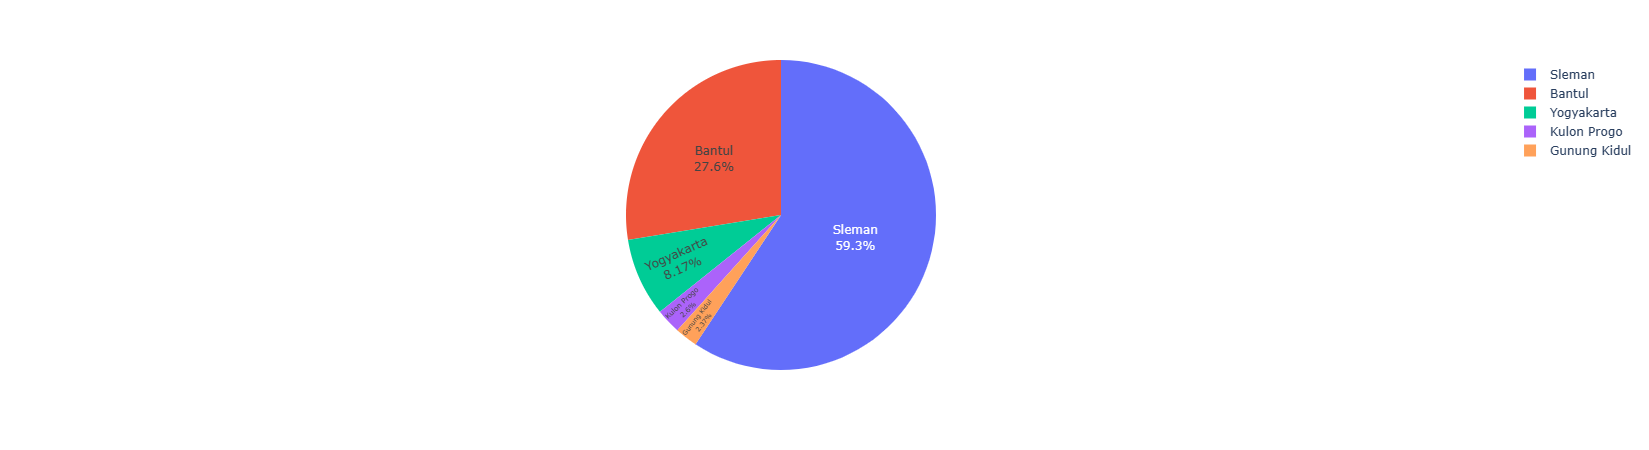

In [13]:
fig=px.pie(names=df['alamat'].value_counts().index,values=df['alamat'].value_counts().values)
fig.update_traces(textposition='inside', textinfo='percent+label')


In [12]:
pip install poppler


ERROR: Could not find a version that satisfies the requirement poppler (from versions: none)
ERROR: No matching distribution found for poppler
Note: you may need to restart the kernel to use updated packages.


In [14]:
def harga_int(data) :
    data=data.replace("Rp ","").replace(".","")
    return float(data)

In [15]:
df['harga']=df['harga'].apply(lambda x:harga_int(x))

In [ ]:
df

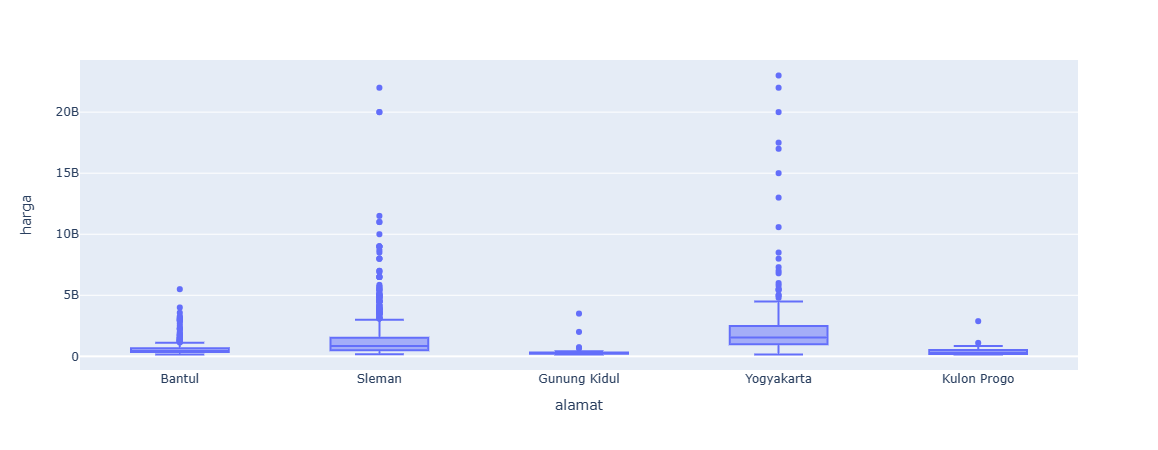

In [17]:
px.box(df,x='alamat',y='harga')

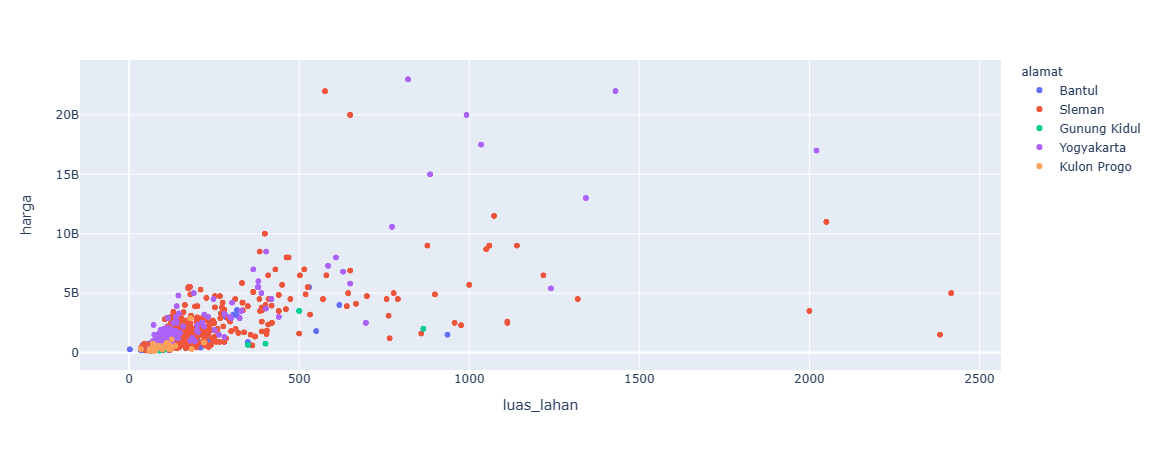

In [22]:
px.scatter(df,y='harga',x='luas_lahan',color='alamat',hover_data={"index" : df['alamat'].index})

In [29]:
df[df.index==1656]

rumah  alamat         harga  temppat_tidur  \
1656  Rumah di ngaglik pinggir jl aspal  Sleman  1.500000e+09              3   

      luas_bangunan  luas_lahan  
1656            180        2384

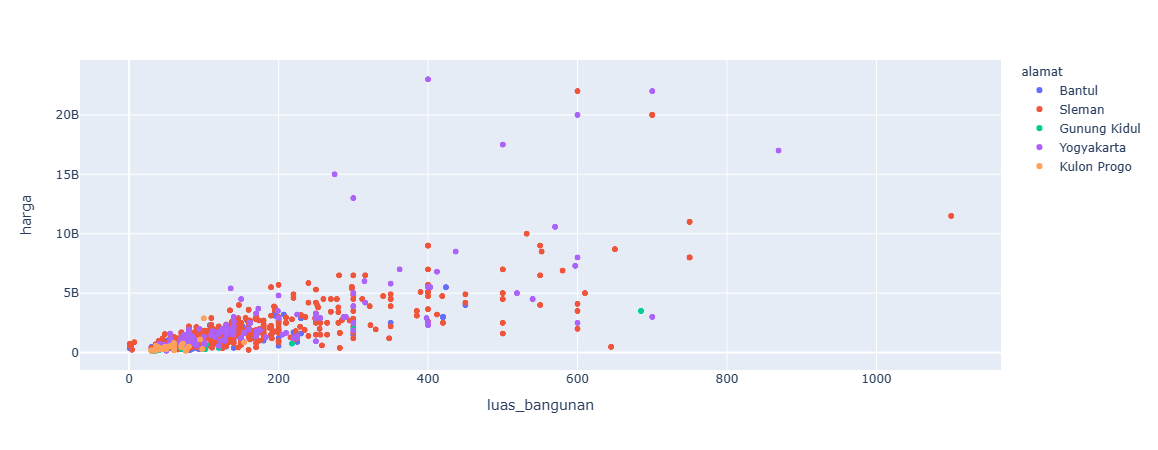

In [31]:
px.scatter(df,y='harga',x='luas_bangunan',color='alamat',hover_data={"index" : df['alamat'].index})

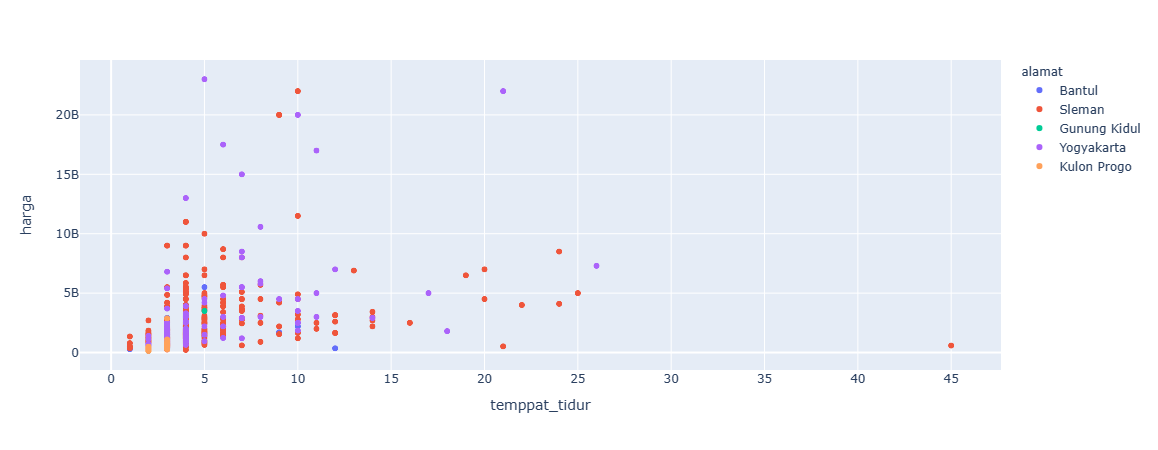

In [32]:
px.scatter(df,y='harga',x='temppat_tidur',color='alamat',hover_data={"index" : df['alamat'].index, "Nama" : df['rumah']})

In [36]:
df.iloc[2073:2074,:]

rumah  alamat        harga  \
2073  Rumah Joglo Terlaris Dekat Candi Prambanan  Sleman  590000000.0   

      temppat_tidur  luas_bangunan  luas_lahan  
2073             45              1         110

In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.add_trace(
    go.Box(
        x=train['species'],y=train[numerical_data[0]],name=numerical_data[0]
    ),
    row=1, col=1
)
fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.2, showarrow=False,
                   text=f"<b>{numerical_data[0]} vs Target</b>", row=1, col=1)

fig.add_trace(
    go.Box(
        x=train['species'],
        y=train[numerical_data[1]],name=numerical_data[1]

    ),
    row=1, col=2
)
fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.2, showarrow=False,
                   text=f"<b>{numerical_data[1]} vs Target</b>", row=1, col=2)
fig.add_trace(
    go.Box(
        x=train['species'],
        y=train[numerical_data[2]],name=numerical_data[2]

    ),
    row=2, col=1
)
fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.2, showarrow=False,
                   text=f"<b>{numerical_data[2]} vs Target</b>", row=2, col=1)
                  
fig.add_trace(
    go.Box(
        x=train['species'],
        y=train[numerical_data[3]],name=numerical_data[3],

    ),
    row=2, col=2
)
fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.2, showarrow=False,
                   text=f"<b>{numerical_data[3]} vs Target</b>", row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Boxplot Numerical data terhadap Target")

fig.show()

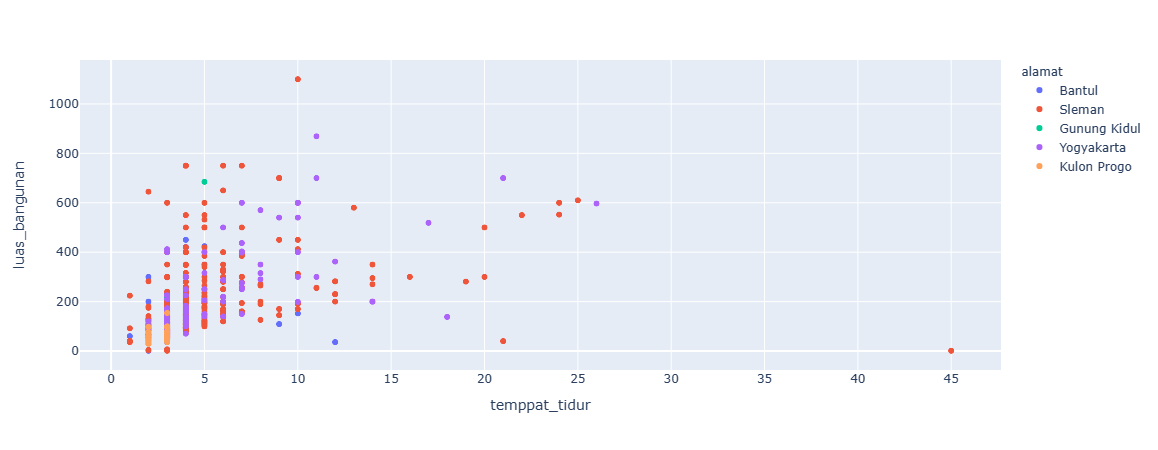

In [33]:
px.scatter(df,x='temppat_tidur',y='luas_bangunan',color='alamat',hover_data={"index" : df['alamat'].index, "Nama" : df['rumah']})

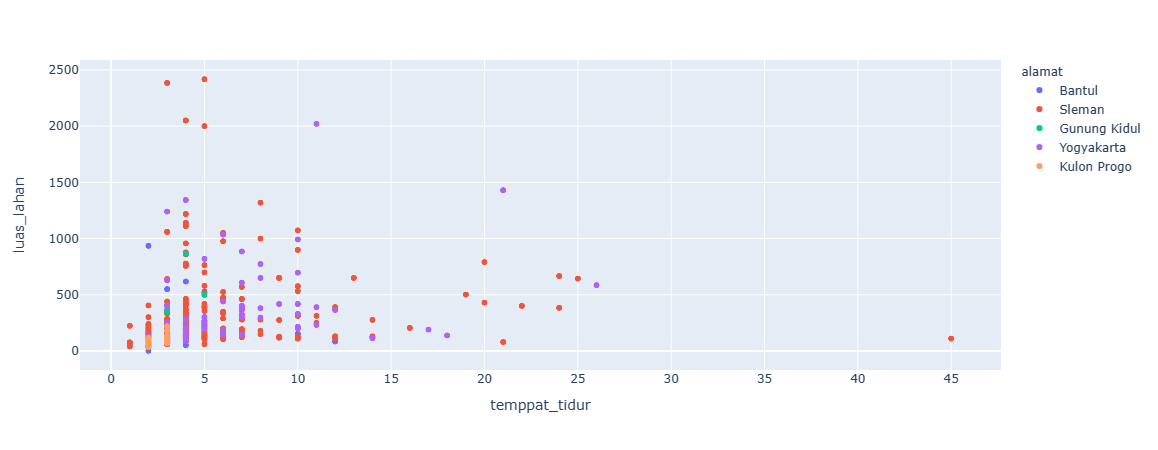

In [34]:
px.scatter(df,x='temppat_tidur',y='luas_lahan',color='alamat',hover_data={"index" : df['alamat'].index, "Nama" : df['rumah']})

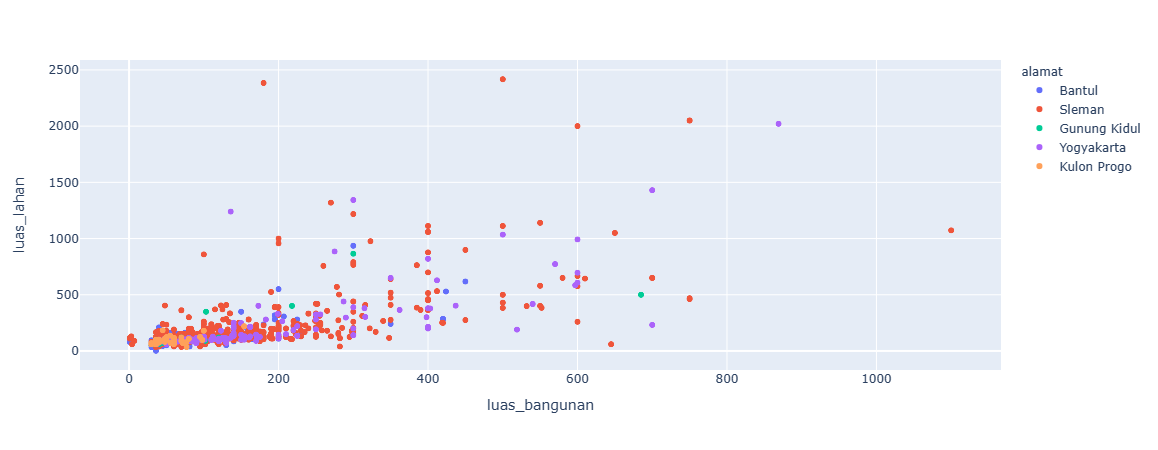

In [35]:
px.scatter(df,x='luas_bangunan',y='luas_lahan',color='alamat',hover_data={"index" : df['alamat'].index, "Nama" : df['rumah']})

<AxesSubplot:>

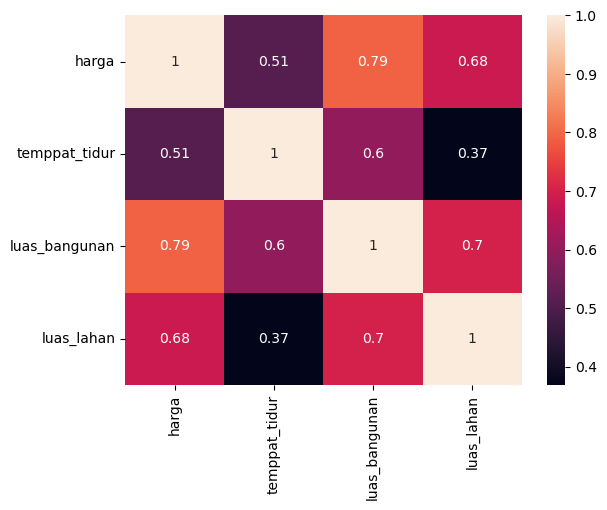

In [38]:
sns.heatmap(df.corr(),annot=True)

## Analisis unstructured data text

In [39]:
train=pd.read_csv("/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv")

In [40]:
train

clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...      -1.0
162976  dear rss terrorist payal gawar what about modi...      -1.0
162977  did you cover her interaction forum where she ...       0.0
162978  there big project came into india modi dream p...       0.0
162979  have you ever listen about like gurukul where ...       1.0

[162980 rows x 2 columns]

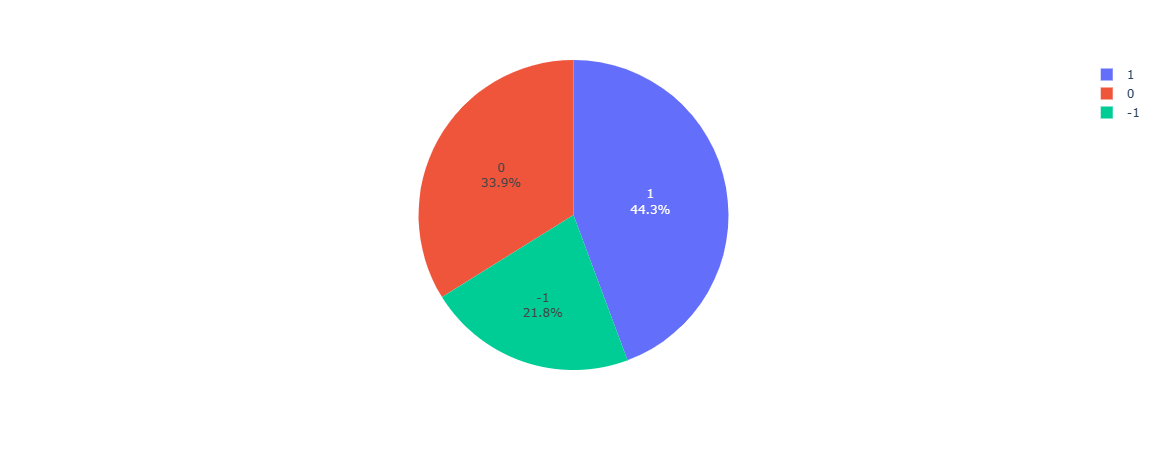

In [42]:
fig=px.pie(names=train["category"].value_counts().index,values=train["category"].value_counts())
fig.update_traces(textposition='inside', textinfo='percent+label')

In [ ]:
def cleaned_review(review):
  
    clean_review = re.sub("[^a-zA-Z]", " ", review)
    
    # convert whole sentence to lowercase and split
    new_words = clean_review.lower().split()
    
    # converting stopwords list to set for faster search
    stops = set(stopwords)
    
    # using stopwords to remove irrelavent words and lemmatizing the final output
    final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stops]
    #remove early whitespace and late whitespace
    final_words=finalwords.lstrip().strip(" ")
    
    # return the final result
    return (" ".join(final_words))

In [48]:
train["msg"]=train["clean_text"]

In [ ]:
train

In [ ]:
train.isnull().sum()

## Hilangkan null value


In [43]:
null_index=train[train["clean_text"].isnull()==True].index
train=train.drop(index=null_index,axis=0)

## Mari kita lihat panjang tiap kalimat

In [45]:
def more_cleaning(word) :
    try :
        if " " in word.lstrip().strip(" ") :
            word=word.strip("  ").strip(" ").lstrip().split(" ")
            try :
                word.remove("")
                return " ".join(word)
            except :
                return " ".join(word)
        else :
            return word
    except :
        return None

In [46]:
def length_sentence(word) :
    try :
        if " " in word.lstrip().strip(" ") :
            word=word.strip("  ").strip(" ").lstrip().split(" ")
            try :
                word.remove("")
                return len(word)
            except :
                return len(word)
        else :
            return 1
    except :
        return None

In [56]:
train["len"] =train["clean_text"].apply(lambda x:length_sentence(x))

In [57]:
train["cleaned"]=train["clean_text"].apply(lambda x:more_cleaning(x))

In [54]:
train.drop('msg',axis=1)

clean_text  category  \
0       when modi promised “minimum government maximum...      -1.0   
1       talk all the nonsense and continue all the dra...       0.0   
2       what did just say vote for modi  welcome bjp t...       1.0   
3       asking his supporters prefix chowkidar their n...       1.0   
4       answer who among these the most powerful world...       1.0   
...                                                   ...       ...   
162975  why these 456 crores paid neerav modi not reco...      -1.0   
162976  dear rss terrorist payal gawar what about modi...      -1.0   
162977  did you cover her interaction forum where she ...       0.0   
162978  there big project came into india modi dream p...       0.0   
162979  have you ever listen about like gurukul where ...       1.0   

                                                  cleaned  
0       when modi promised “minimum government maximum...  
1       talk all the nonsense and continue all the dra...  
2       what did just say vote for modi welcome bjp to...  
3       asking his supporters prefix chowkidar their n...  
4       answer who among these the most powerful world...  
...                                                   ...  
162975  why these 456 crores paid neerav modi not reco...  
162976  dear rss terrorist payal gawar what about modi...  
162977  did you cover her interaction forum where she ...  
162978  there big project came into india modi dream p...  
162979  have you ever listen about like gurukul where ...  

[162976 rows x 3 columns]

plot 1000 data terbanyak

In [58]:
data=train["len"].sort_values(ascending=False).head(1000)

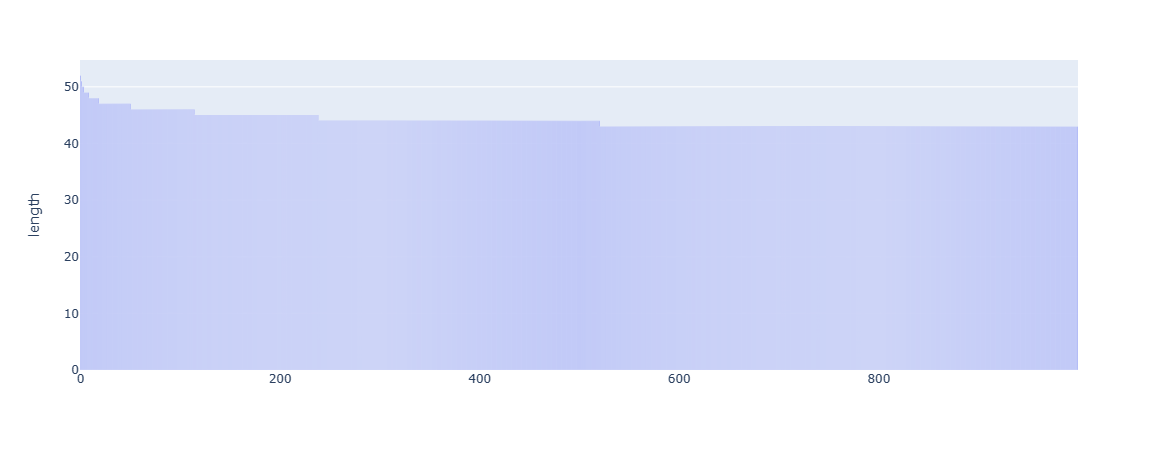

In [59]:
fig=px.bar(y=data)
fig.update_layout(xaxis_title="",yaxis_title="length")



<b> Persebaran data pada 1000 kalimat terpanjang</b> 

    Pada persebaran panjang kalimat 1000 data dengan length terpanjang tersebut dapat dilihat bahwa data ini memiliki panjang maksimal sepanjang 52 dan akan terus menurun namun penurunnya sampai ke data 1000 terpanjang cukup kecil


<b>Persebaran 1000 data terpendek<b/>

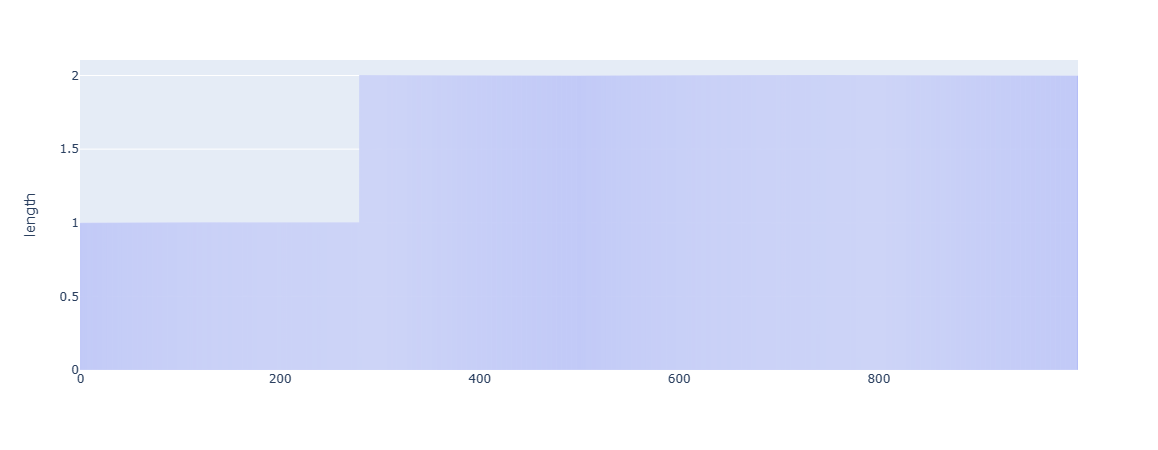

In [60]:
data=train["len"].sort_values(ascending=True).head(1000)
fig=px.bar(y=data)
fig.update_layout(xaxis_title="",yaxis_title="length")
fig.show()

1000 data terpendek memiliki panjang kurang dari 3 kata dengan kata paling sedikit ada 1 kata

mari kita lihat data dengan kata terpendek


In [64]:
train[train.len==2]

clean_text  category            msg      cleaned  len
35         only modi        0.0     only modi     only modi    2
57        itna fark         0.0    itna fark      itna fark    2
264        good read        1.0     good read     good read    2
270         modi for        0.0      modi for      modi for    2
456        must read        0.0     must read     must read    2
...               ...       ...            ...          ...  ...
162156   yes because        0.0   yes because   yes because    2
162322    haters 23rd       0.0    haters 23rd  haters 23rd    2
162595     yes love\n       1.0     yes love\n   yes love\n    2
162831  retweet  for        0.0  retweet  for   retweet for    2
162930       wha modi       0.0       wha modi     wha modi    2

[916 rows x 5 columns]

## Emoji

In [61]:
import emoji

In [ ]:
emoji

In [65]:

lists=set()
for i in train.cleaned :
    for j in i.strip(" ") :
        if emoji.is_emoji(j) :
            lists.add(j)
nonempty_dict = dict.fromkeys(lists,0)
for i in train.cleaned :
    for j in i.strip(" ") :
        if emoji.is_emoji(j) :
            nonempty_dict[j]+=1

           

In [66]:
nonempty_dict

{'☺': 218,
 '⛺': 1,
 '☠': 19,
 '⛱': 1,
 '‼': 40,
 '✈': 22,
 '⏺': 1,
 '✔': 26,
 '〰': 3,
 '☕': 15,
 '⛔': 23,
 '✊': 29,
 '™': 3,
 '⭐': 8,
 '⛵': 1,
 '©': 4,
 '➖': 5,
 '◀': 1,
 '✡': 1,
 '☝': 63,
 '⤴': 2,
 '®': 6,
 '▪': 50,
 '⏫': 1,
 '⬇': 11,
 '❔': 3,
 '⁉': 12,
 '✅': 64,
 '✏': 1,
 '⛽': 1,
 '☀': 1,
 '☎': 3,
 '☹': 20,
 '☮': 1,
 '♦': 18,
 '➗': 1,
 '⚖': 4,
 '⛅': 1,
 '♻': 3,
 '↪': 3,
 '⭕': 3,
 '❣': 22,
 '⬆': 4,
 '✨': 13,
 '✌': 463,
 '♀': 109,
 '➡': 46,
 '♿': 1,
 '⏩': 22,
 '❗': 6,
 '✋': 38,
 '➿': 1,
 '◾': 1,
 '⏰': 2,
 '❎': 4,
 '❓': 27,
 '❤': 328,
 '➕': 5,
 '♂': 314,
 '☑': 3,
 '♥': 47,
 '❌': 14,
 '✍': 14,
 '⚠': 12,
 '⌚': 5,
 '♨': 2,
 '⚡': 560,
 '▶': 21,
 '✖': 3,
 '↗': 1,
 '⚛': 7,
 '☄': 1,
 '⛳': 18,
 '⤵': 8}

In [67]:
sort_emoji=dict(sorted(nonempty_dict.items(), key=lambda item: item[1],reverse=True))

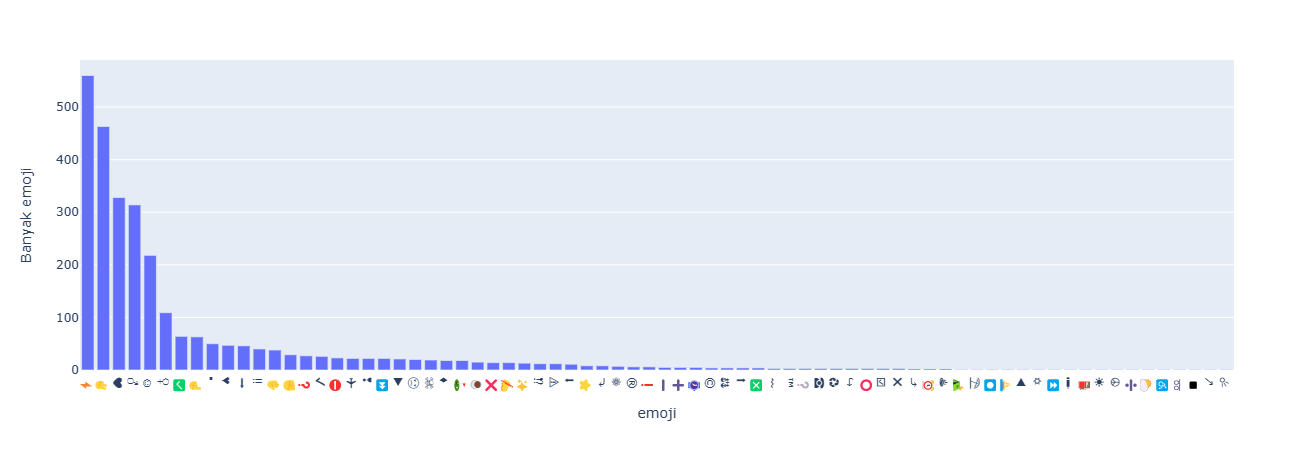

In [69]:
px.bar(x=sort_emoji.keys(),y=list(sort_emoji.values())).update_layout(xaxis_title="emoji",yaxis_title="Banyak emoji")

emoji ⚡ memiliki jumlah terbanyak, diikuti dengan emoji ✌ dan ada beberapa emoji yang hanya muncul sekali. 


## Word Clouds


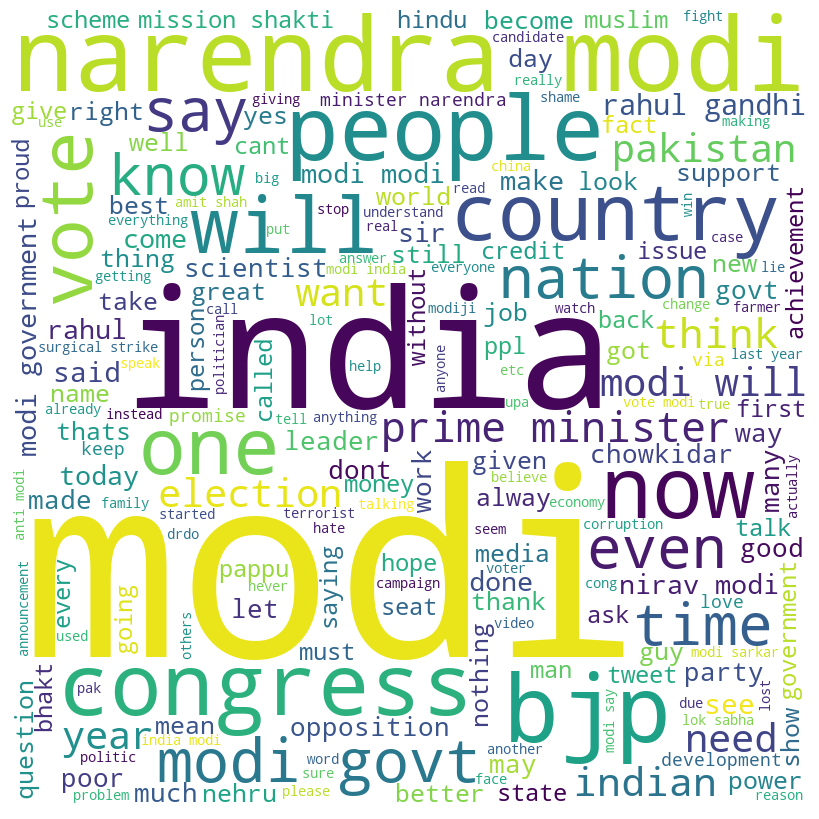

In [72]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(train["cleaned"]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig("squares.png")
 
plt.show()